COMP5329 – Deep Learning
Assignment 1
Team: 
-	vyun8699 - 530454874
-	gzha9095 – 500543568

Note on imports:
- You are NOT allowed to use Deep Learning frameworks (e.g. PyTorch, Tensorflow, Caffe, and KERAS), or any kinds of auto-grad tools (e.g. autograd).
- Scientific computing packages, such as NumPy and SciPy, are acceptable. 

Note on code sources:
- Week 3: activation function, hidden layers, MLP
- Week 4: momentum, AdaGrad, Adam, SGD
- Week 5: dropout, batch normalization

Code penalties:
- well organized, commented, documented [5]
- Badly written code [-20]
- Not including instructions on how to run code (ie. readme.txt) [-30]

In [1]:
#imports A
import numpy as np
import matplotlib.pyplot as plt
import time # to track model speeds
from sklearn.metrics import classification_report, confusion_matrix 

In [2]:
# Data loading
train_data = np.load('Assignment1-Dataset/train_data.npy')
train_label = np.load('Assignment1-Dataset/train_label.npy')
test_data = np.load('Assignment1-Dataset/test_data.npy')
test_label = np.load('Assignment1-Dataset/test_label.npy')

# set mean to 0 with standard deviation 1
train_mean = np.mean(train_data)
train_std = np.std(train_data)
adj_train_data = (train_data - train_mean) / train_std
adj_test_data = (test_data - train_mean) / train_std

In [3]:
# data size scaler
# this is intended to help with initial build (e.g. rather than going through 50k of datapoints, we go through factor * 50k)

def create_smaller_dataset(train_data, train_label, n, random_state = None):
    smaller_data = []
    smaller_label = []
    
    unique_labels = np.unique(train_label)

    rs_generator = np.random.RandomState(random_state)
    
    for label in unique_labels:
        label_indices = np.where(train_label == label)[0]
        selected_indices = rs_generator.choice(label_indices, size=int(n*len(label_indices)), replace=False)
        
        smaller_data.extend(train_data[selected_indices])
        smaller_label.extend(train_label[selected_indices])
    
    smaller_data = np.array(smaller_data)
    smaller_label = np.array(smaller_label)

    #reshuffle data because for some reason everything is grouped by class again
    shuffled_indices = np.arange(len(smaller_data))
    rs_generator.shuffle(shuffled_indices)
    smaller_data = smaller_data[shuffled_indices]
    smaller_label = smaller_label[shuffled_indices]
    
    print(f'random_state:{random_state}, input_data: {smaller_data.shape}, output_data: {smaller_label.shape}')
    
    return smaller_data, smaller_label


In [4]:
def plot_results(input_data, output_data, cross_entropy):
    #PLOTS
    #plot loss
    plt.figure(figsize=(10,4))
    plt.title('Cross entropy loss over epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(cross_entropy)
    plt.grid()

    '''
    # plot prediction
    output_unique_values, output_counts = np.unique(output, return_counts=True)
    true_label_unique_values, true_label_counts = np.unique(output_data, return_counts=True)

    # Set up the matplotlib figure and axes, one for each bar chart
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

    # Plot for 'output'
    axs[0].bar(output_unique_values, output_counts)
    axs[0].set_xticks(output_unique_values)
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Count')
    axs[0].set_title(f'Count of Predicted Labels n:{len(output)}')

    # Plot for 'true_label'
    axs[1].bar(true_label_unique_values, true_label_counts)
    axs[1].set_xticks(true_label_unique_values)
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Count')
    axs[1].set_title(f'Count of True Labels n:{len(output_data)}')

    plt.tight_layout()  # Adjust the layout to fit both subplots
    plt.show()
    '''

def print_scores(train_data, test_data, train_label, test_label):

   #scores
   print('train scores:')
   print(classification_report(train_label, nn.predict(train_data)))
   #print(confusion_matrix(train_label, nn.predict(train_data)))
   
   print('test scores')
   print(classification_report(test_label, nn.predict(test_data)))
   #print(confusion_matrix(test_label, nn.predict(test_data)))

In [5]:
# all classes are contained here

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    #added in: ReLu

    def __relu(self, x):
        return np.maximum(0,x)

    def __relu_deriv(self, a):
        return np.where(a>0,1,0)
    
    #added in: softmax

    def __softmax(self,x): 
        ''' 
            https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
            https://www.geeksforgeeks.org/how-to-implement-softmax-and-cross-entropy-in-python-and-pytorch/
            
            we subtract np.max in the exps calculation to solve overflow (for large x values) and maintain stability
            reasoning: if we subtract everything by np.max, then largest value is exp(0) = 1
        '''
        exps = np.exp( x -np.max(x, axis =-1, keepdims = True))
        return exps / np.sum(exps, axis =-1, keepdims = True)

    def __softmax_deriv(self,yhat, y_one_hot):
        '''
        https://www.pinecone.io/learn/cross-entropy-loss/
        gradient is the diff between predicted and true values
        '''
        return yhat - y_one_hot 

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv

class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        # if activation == 'logistic':
        #     self.W *= 4

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set the size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    
    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes. 
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    #updated to handle softmax at output layer
    def backward(self, delta, output_layer=False):         
        '''
        Note that the output_layer toggle is not used as backward pass calculation is uniform everywhere
        Note backward calculates grad_W and grad_b for the HiddenLayer object, while the iterator is housed in MLP
        '''
        
        self.grad_W = np.dot(np.atleast_2d(self.input).T, np.atleast_2d(delta))
        self.grad_b = np.sum(delta, axis = 0) 
        if self.activation_deriv: 
            delta = np.dot(delta, self.W.T) * self.activation_deriv(self.input)

        return delta
    
class MLP:
    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','softmax']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[] # this doesnt do anything
        
        self.activation=activation
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:  # Check if it's the last hidden layer
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1], W=np.random.uniform(
                            low=-np.sqrt(6. / (layers[i] + layers[i + 1])),
                            high=np.sqrt(6. / (layers[i] + layers[i + 1])),
                            size=(layers[i], layers[i + 1])).T)
                self.layers.append(hidden_layer)
            else:
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1])
                self.layers.append(hidden_layer)


    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output

    # define the objection/loss function, we use mean sqaure error (MSE) as the loss
    # you can try other loss, such as cross entropy.
    # when you try to change the loss, you should also consider the backward formula for the new loss as well!
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        error = y-y_hat
        loss=error**2
        # calculate the MSE's delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta

    #implement cross entropy, mimic input and output of MSE
    def criterion_cross_entropy(self, y, y_hat):
        '''
        shape of y = (1,) <-- a single integer of true class
        shape of y_hat = (10,) <-- values corresponding to each class
        '''
        activation_deriv=Activation(self.activation[-1]).f_deriv
        
        #one hot encode y to match shape of y_hat, value is 0 everywhere, 1 for the positive column
        num_classes = y_hat.shape[0] 
        num_samples = y.shape[0]
        y_one_hot = np.zeros((num_samples,num_classes)) 
        y_one_hot[np.arange(num_samples),y.flatten()] = 1 
        
        # calculate loss, add epsilon to avoid log 0
        loss = np.sum(- y_one_hot * np.log(y_hat + 1e-9)) 
        
        #calculate delta of output layer 
        delta = activation_deriv(y_hat, y_one_hot)

        #return loss and delta
        return loss, delta

    # backward progress  
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]): #self.layers[:-1] returns the list excluding the last element
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!  
    # note: added assert for debugging  
    def update(self,lr):
        for layer in self.layers:
            assert layer.W.shape == layer.grad_W.shape, 'mismatch in W and grad_W shapes'
            assert layer.b.shape == layer.grad_b.shape, f'mismatch in b {layer.b.shape} and grad_b shapes {layer.grad_b.shape}'
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                #print(y_hat.shape)
                
                # backward pass
                #loss[it],delta=self.criterion_MSE(y[i],y_hat)
                loss[it],delta=self.criterion_cross_entropy(y[i],y_hat)
                
                #backward pass
                self.backward(delta)
                
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        '''adjusted to account for softmax output layer'''
        x = np.array(x)
        output = np.zeros((x.shape[0], 1))  # Prepare output array to store predicted class labels
        for i in np.arange(x.shape[0]):
            probabilities = self.forward(x[i, :])  # Get the softmax probabilities
            predicted_class = np.argmax(probabilities)  # Choose the class with the highest probability
            output[i] = int(predicted_class)  # Assign the predicted class to the output array
        return output

random_state:42, input_data: (50000, 128), output_data: (50000, 1)


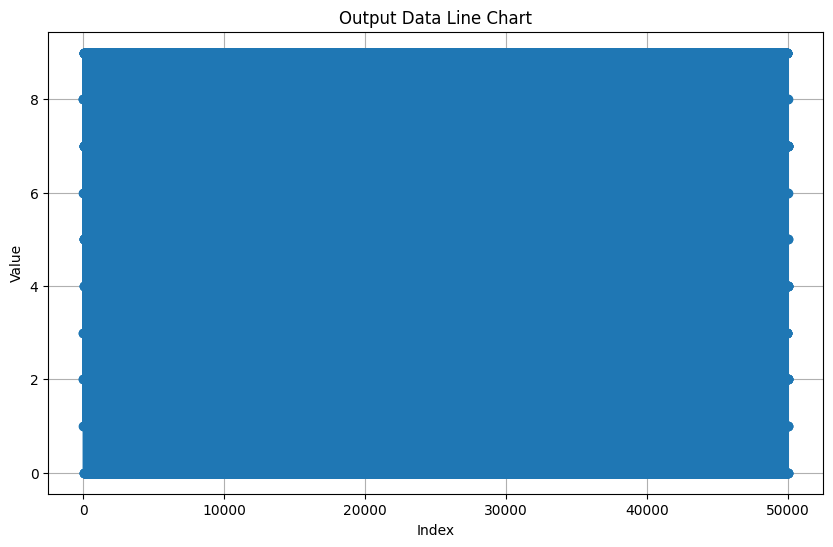

In [6]:
#data prep
data_proportion = 1
random_state = 42
input_data, output_data = create_smaller_dataset(adj_train_data, train_label, data_proportion, random_state = random_state)
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.plot(output_data, marker='o', linestyle='-')  # Plot the data with markers
plt.title('Output Data Line Chart')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('Value')  # Y-axis label
plt.grid(True)  # Show grid lines (optional)
plt.show()  # Display the plot

loss:1.222602
train scores:
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      5000
           1       0.70      0.66      0.68      5000
           2       0.42      0.50      0.46      5000
           3       0.40      0.38      0.39      5000
           4       0.49      0.46      0.47      5000
           5       0.49      0.42      0.45      5000
           6       0.53      0.71      0.61      5000
           7       0.70      0.54      0.61      5000
           8       0.66      0.73      0.69      5000
           9       0.65      0.58      0.61      5000

    accuracy                           0.56     50000
   macro avg       0.56      0.56      0.56     50000
weighted avg       0.56      0.56      0.56     50000

test scores
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      1000
           1       0.63      0.60      0.62      1000
           2       0.36      0.45     

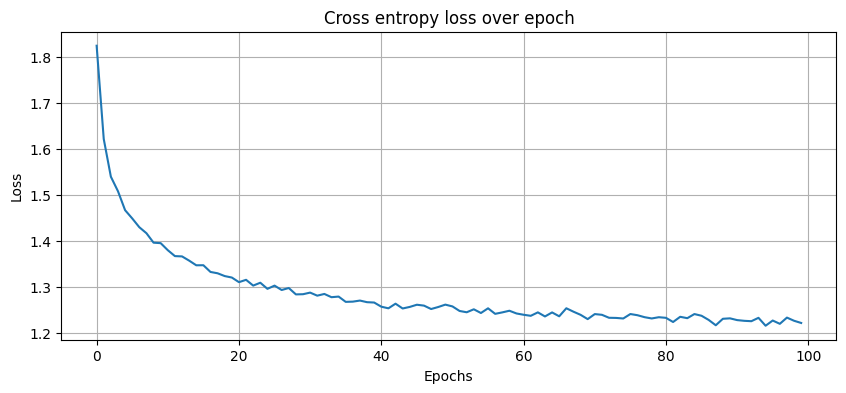

In [7]:
# 2 LAYERS WIDTH 32, 100 EPOCH

# fit model
nn = MLP([128,32,32,10], [None,'relu','relu','softmax'])
lr = 0.001
epoch_count = 100

# calculate cross entropy
cross_entropy = nn.fit(input_data, output_data, learning_rate = lr, epochs = epoch_count)
print('loss:%f'%cross_entropy[-1])

# predict output
output = nn.predict(input_data)

#show results
plot_results(input_data, output_data, cross_entropy)
print_scores(adj_train_data, adj_test_data, train_label, test_label)

## 5 minutes loss 1.22

loss:0.992642
train scores:
              precision    recall  f1-score   support

           0       0.74      0.62      0.67      5000
           1       0.74      0.81      0.77      5000
           2       0.53      0.54      0.54      5000
           3       0.48      0.45      0.46      5000
           4       0.55      0.61      0.58      5000
           5       0.56      0.52      0.54      5000
           6       0.65      0.71      0.68      5000
           7       0.76      0.67      0.71      5000
           8       0.75      0.79      0.77      5000
           9       0.72      0.74      0.73      5000

    accuracy                           0.65     50000
   macro avg       0.65      0.65      0.64     50000
weighted avg       0.65      0.65      0.64     50000

test scores
              precision    recall  f1-score   support

           0       0.59      0.50      0.54      1000
           1       0.58      0.62      0.60      1000
           2       0.38      0.40     

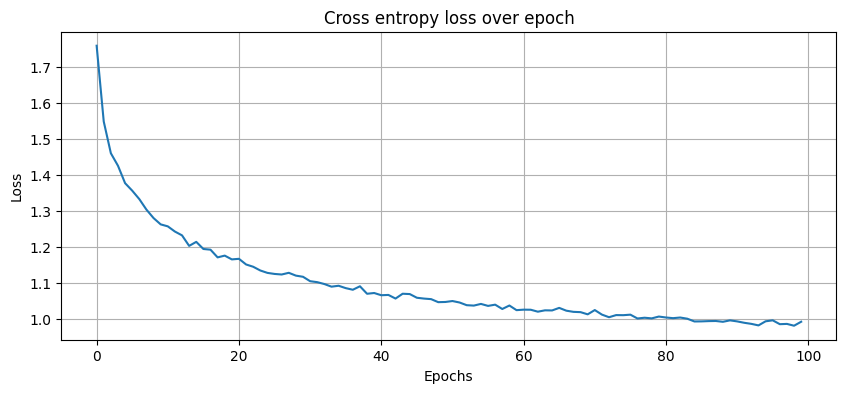

In [8]:
# 2 LAYERS WIDTH 64, 100 EPOCH

# fit model
nn = MLP([128,64,64,10], [None,'relu','relu','softmax'])
lr = 0.001
epoch_count = 100

# calculate cross entropy
cross_entropy = nn.fit(input_data, output_data, learning_rate = lr, epochs = epoch_count)
print('loss:%f'%cross_entropy[-1])

# predict output
output = nn.predict(input_data)

#show results
plot_results(input_data, output_data, cross_entropy)
print_scores(adj_train_data, adj_test_data, train_label, test_label)

## 6mins44sec loss 0.99

loss:1.208919
train scores:
              precision    recall  f1-score   support

           0       0.62      0.61      0.62      5000
           1       0.65      0.73      0.68      5000
           2       0.49      0.38      0.43      5000
           3       0.39      0.46      0.42      5000
           4       0.50      0.47      0.48      5000
           5       0.48      0.42      0.45      5000
           6       0.59      0.63      0.61      5000
           7       0.65      0.64      0.64      5000
           8       0.61      0.78      0.69      5000
           9       0.68      0.53      0.59      5000

    accuracy                           0.57     50000
   macro avg       0.57      0.57      0.56     50000
weighted avg       0.57      0.57      0.56     50000

test scores
              precision    recall  f1-score   support

           0       0.56      0.58      0.57      1000
           1       0.58      0.64      0.61      1000
           2       0.42      0.33     

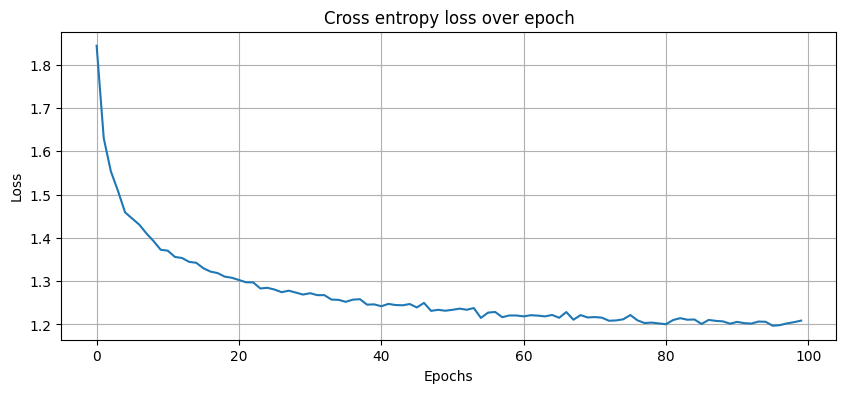

In [9]:
# 3 LAYERS WIDTH 32, 100 EPOCH

# fit model
nn = MLP([128,32,32,32, 10], [None,'relu','relu','relu','softmax'])
lr = 0.001
epoch_count = 100

# calculate cross entropy
cross_entropy = nn.fit(input_data, output_data, learning_rate = lr, epochs = epoch_count)
print('loss:%f'%cross_entropy[-1])

# predict output
output = nn.predict(input_data)

#show results
plot_results(input_data, output_data, cross_entropy)
print_scores(adj_train_data, adj_test_data, train_label, test_label)

#9m13s loss 1.2

loss:1.055603
train scores:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69      5000
           1       0.71      0.76      0.74      5000
           2       0.49      0.56      0.52      5000
           3       0.48      0.43      0.45      5000
           4       0.58      0.48      0.52      5000
           5       0.56      0.44      0.49      5000
           6       0.63      0.73      0.67      5000
           7       0.68      0.72      0.70      5000
           8       0.72      0.79      0.76      5000
           9       0.71      0.66      0.68      5000

    accuracy                           0.63     50000
   macro avg       0.62      0.63      0.62     50000
weighted avg       0.62      0.63      0.62     50000

test scores
              precision    recall  f1-score   support

           0       0.56      0.61      0.58      1000
           1       0.62      0.65      0.64      1000
           2       0.37      0.43     

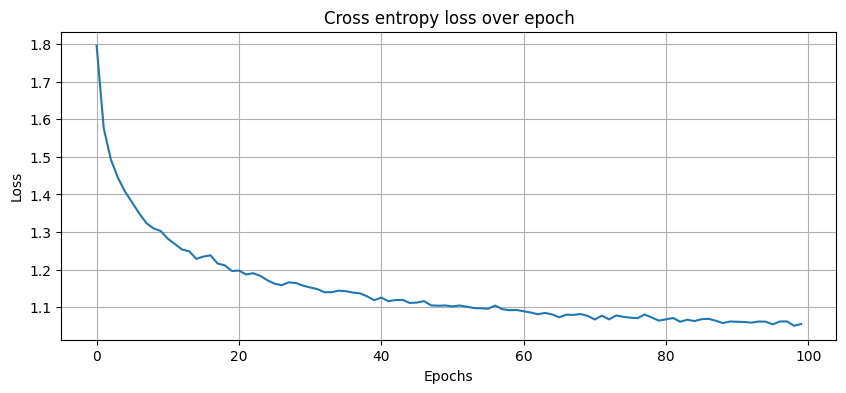

In [10]:
# 2 LAYERS WIDTH 64 AND 32, 100 EPOCH

# fit model
nn = MLP([128,64,32, 10], [None,'relu','relu','softmax'])
lr = 0.001
epoch_count = 100

# calculate cross entropy
cross_entropy = nn.fit(input_data, output_data, learning_rate = lr, epochs = epoch_count)
print('loss:%f'%cross_entropy[-1])

# predict output
output = nn.predict(input_data)

#show results
plot_results(input_data, output_data, cross_entropy)
print_scores(adj_train_data, adj_test_data, train_label, test_label)

#8m35s loss 1.05

loss:1.052455
train scores:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      5000
           1       0.74      0.74      0.74      5000
           2       0.56      0.43      0.49      5000
           3       0.42      0.57      0.48      5000
           4       0.49      0.64      0.55      5000
           5       0.56      0.39      0.46      5000
           6       0.72      0.66      0.69      5000
           7       0.71      0.69      0.70      5000
           8       0.69      0.80      0.74      5000
           9       0.73      0.66      0.69      5000

    accuracy                           0.62     50000
   macro avg       0.63      0.62      0.62     50000
weighted avg       0.63      0.62      0.62     50000

test scores
              precision    recall  f1-score   support

           0       0.60      0.57      0.58      1000
           1       0.63      0.62      0.62      1000
           2       0.43      0.34     

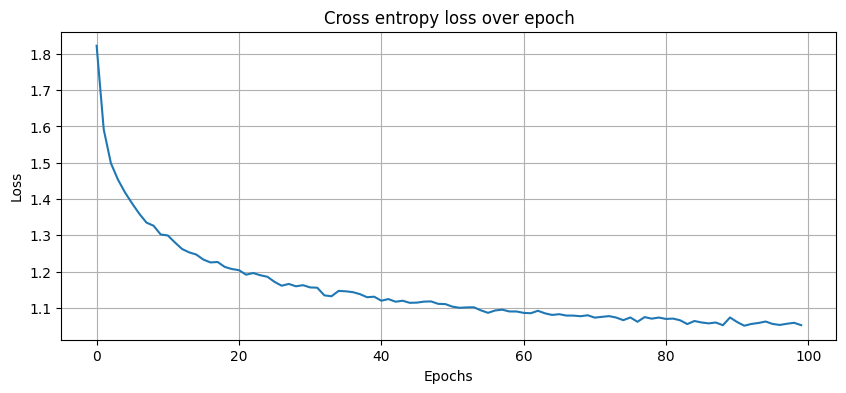

In [11]:
# 3 LAYERS WIDTH 64, 32, 16, 100 EPOCH

# fit model
nn = MLP([128,64,32,16, 10], [None,'relu','relu','relu','softmax'])
lr = 0.001
epoch_count = 100

# calculate cross entropy
cross_entropy = nn.fit(input_data, output_data, learning_rate = lr, epochs = epoch_count)
print('loss:%f'%cross_entropy[-1])

# predict output
output = nn.predict(input_data)

#show results
plot_results(input_data, output_data, cross_entropy)
print_scores(adj_train_data, adj_test_data, train_label, test_label)

#11min, loss 1.05

loss:0.896421
train scores:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      5000
           1       0.80      0.79      0.79      5000
           2       0.57      0.58      0.58      5000
           3       0.54      0.52      0.53      5000
           4       0.62      0.60      0.61      5000
           5       0.61      0.54      0.57      5000
           6       0.72      0.71      0.72      5000
           7       0.75      0.77      0.76      5000
           8       0.83      0.74      0.78      5000
           9       0.68      0.79      0.73      5000

    accuracy                           0.68     50000
   macro avg       0.68      0.68      0.68     50000
weighted avg       0.68      0.68      0.68     50000

test scores
              precision    recall  f1-score   support

           0       0.55      0.61      0.58      1000
           1       0.61      0.57      0.59      1000
           2       0.38      0.40     

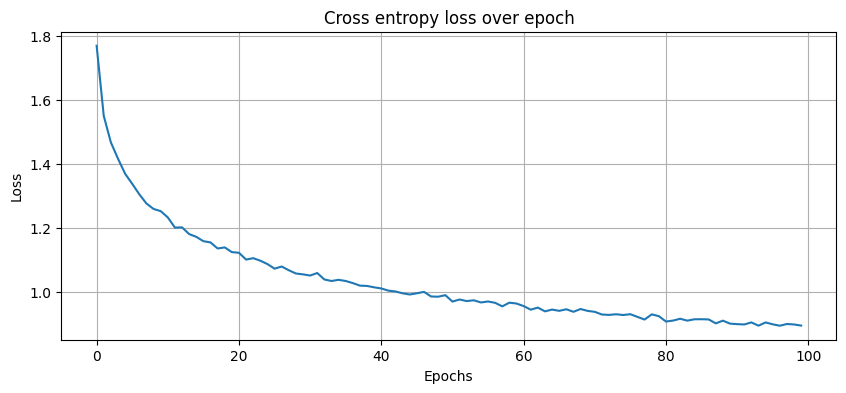

In [12]:
# 3 LAYERS WIDTH 64, 100 EPOCH

# fit model
nn = MLP([128,64,64,64, 10], [None,'relu','relu','relu','softmax'])
lr = 0.001
epoch_count = 100

# calculate cross entropy
cross_entropy = nn.fit(input_data, output_data, learning_rate = lr, epochs = epoch_count)
print('loss:%f'%cross_entropy[-1])

# predict output
output = nn.predict(input_data)

#show results
plot_results(input_data, output_data, cross_entropy)
print_scores(adj_train_data, adj_test_data, train_label, test_label)

#9m55s loss 0.89